<a href="https://colab.research.google.com/github/ThalhaAnas/Machine-Learning-CW/blob/main/CW_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [24]:
import pandas as pd

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [25]:
#handle Missing and invalid values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

#convert senior citizen to Yes/No
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

df = df.drop('customerID', axis=1)

In [26]:
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in service_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})


### Sperate features and label

In [27]:
X = df.drop('Churn', axis=1)
y = df['Churn']

y = y.map({'No':0, 'Yes':1})

#convert cateogorical features to binary
X = pd.get_dummies(X, drop_first= True)

### Split data and scale for NN

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

#Scale data for NN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

###Print shapes to confirm data pipeline

In [29]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5625, 23)
X_test shape: (1407, 23)
X_train_scaled shape: (5625, 23)
y_train shape: (5625,)
y_test shape: (1407,)


# DECISION TREE CLASSIFIER

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

#Evaluate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")

Decision Tree Accuracy: 0.7000710732054015


### Evaluation

In [31]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Confusion Matrix:
[[820 213]
 [209 165]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      1033
           1       0.44      0.44      0.44       374

    accuracy                           0.70      1407
   macro avg       0.62      0.62      0.62      1407
weighted avg       0.70      0.70      0.70      1407



### Hyperparameter tuning

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid to search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'criterion': ['gini', 'entropy']            # splitting method
}

# Create the GridSearchCV model
dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1               # use all CPU cores for speed
)

# Fit the grid search model
dt_grid.fit(X_train, y_train)


print("Best Parameters:", dt_grid.best_params_)
print("Best Cross-Validation Accuracy:", dt_grid.best_score_)


Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.7905777777777778


### Best tuned Decision Tree

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Best model found by GridSearchCV
best_dt = dt_grid.best_estimator_

# Predict on test data
y_pred_best_dt = best_dt.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best_dt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_dt))


Tuned Model Accuracy: 0.7846481876332623

Confusion Matrix:
[[955  78]
 [225 149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.66      0.40      0.50       374

    accuracy                           0.78      1407
   macro avg       0.73      0.66      0.68      1407
weighted avg       0.77      0.78      0.77      1407



Decision Tree Heatmap

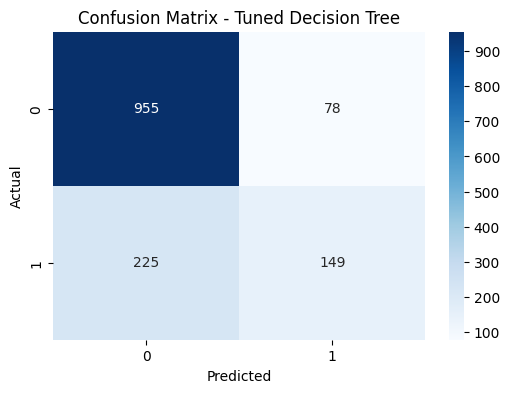

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_dt = confusion_matrix(y_test, y_pred_best_dt)

plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# NEURAL NETWORK MODEL

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Build Model

In [37]:
nn_model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') #output layer (binary classification)
])

nn_model.compile(
    optimizer  = 'adam',
    loss       = 'binary_crossentropy',
    metrics    = ['accuracy']
)

nn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [38]:
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6521 - loss: 0.6074 - val_accuracy: 0.7876 - val_loss: 0.4292
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7944 - loss: 0.4431 - val_accuracy: 0.7929 - val_loss: 0.4130
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8006 - loss: 0.4295 - val_accuracy: 0.7929 - val_loss: 0.4102
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8121 - loss: 0.4111 - val_accuracy: 0.7964 - val_loss: 0.4099
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8048 - loss: 0.4118 - val_accuracy: 0.7964 - val_loss: 0.4092
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8052 - loss: 0.4194 - val_accuracy: 0.7902 - val_loss: 0.4110
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7997 - loss: 0.4205 - val_accuracy: 0.7867 - val_loss: 0.4159
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8086 - loss: 0.4149 - val_accuracy:

### Evaluation

In [39]:
# Predict probabilities
y_pred_nn_prob = nn_model.predict(X_test_scaled)

# Convert probabilities to class labels (0/1)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

# Accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Neural Network Accuracy:", accuracy_nn)

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Accuracy: 0.7931769722814499

Confusion Matrix:
[[919 114]
 [177 197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



### Hyperparameter tuning

In [ ]:
from tensorflow.keras import layers, Sequential
from sklearn.metrics import accuracy_score

def build_model(neurons):
    model = Sequential([
        layers.Dense(neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        layers.Dense(int(neurons/2), activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#Tuning options
neuron_options = [16, 32, 64]
epoch_options = [20, 30]

#Run tuning loop

results = []

for neurons in neuron_options:
    for epochs in epoch_options:
        print(f"Training model: neurons={neurons}, epochs={epochs}")

        model = build_model(neurons)

        model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=32,
            verbose=0  # keep output clean
        )

        y_pred_prob = model.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)

        results.append({
            'neurons': neurons,
            'epochs': epochs,
            'accuracy': acc
        })



Training model: neurons=16, epochs=20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#view results and find best model

results_df = pd.DataFrame(results)
print(results_df)

best_params = results_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_params


### Train best NN and Evaluate

In [ ]:
best_neurons = int(best_params['neurons'])
best_epochs = int(best_params['epochs'])

best_nn_model = build_model(best_neurons)

best_nn_model.fit(
    X_train_scaled, y_train,
    epochs=best_epochs,
    batch_size=32,
    verbose=1
)

from sklearn.metrics import classification_report, confusion_matrix

y_pred_best_prob = best_nn_model.predict(X_test_scaled)
y_pred_best = (y_pred_best_prob > 0.5).astype(int)

print("Tuned NN Accuracy:", accuracy_score(y_test, y_pred_best))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


NN tuned Heatmap

In [ ]:
cm_nn = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Tuned Neural Network")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


NN Training curves

In [ ]:
# Accuracy Curve
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model comparison

In [ ]:
#Model comparison table

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

table = ax.table(
    cellText=comparison_df.round(4).values,
    colLabels=comparison_df.columns,
    rowLabels=comparison_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.title("Model Performance Comparison Table")
plt.show()

#Model comparison Bar Chart
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Create helper function
def get_scores(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

# Calculate scores for all four models
results = {
    "Baseline Decision Tree": get_scores(y_test, y_pred_dt),
    "Tuned Decision Tree": get_scores(y_test, y_pred_best_dt),
    "Baseline Neural Network": get_scores(y_test, y_pred_nn),
    "Tuned Neural Network": get_scores(y_test, y_pred_best)
}

# Convert results to DataFrame
comparison_df = pd.DataFrame(results).T

# Display nicely
print("\nModel Performance Comparison:")
comparison_df

#Comparison Bar Chart

import matplotlib.pyplot as plt
import pandas as pd

# Reuse your comparison_df
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

comparison_df_plot = comparison_df.copy()
comparison_df_plot.index = ["Baseline DT", "Tuned DT", "Baseline NN", "Tuned NN"]

plt.figure(figsize=(12,6))

comparison_df_plot[metrics].plot(kind='bar', figsize=(12,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

